<a href="https://colab.research.google.com/github/honicky/quantization-experiments/blob/main/bitnet_1_58b_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

## Slightly modified BitNet code

I've modified the following code from the BitLinear implementation for the paper reproduction: https://huggingface.co/1bitLLM/bitnet_b1_58-3B/blob/main/utils_quant.py

I've changed it to special case the 1.58b quantization, and use the previous quantization from bitnet for other values


In [ ]:
from torch import nn

def weight_quant_158b(weight, num_bits=1):
    dtype = weight.dtype
    weight = weight.float()
    s = 1 / weight.abs().mean().clamp(min=1e-5)
    result = (weight * s).round().clamp(-1, 1) / s
    return result.type(dtype)

def weight_quant(x, num_bits=8):
    dtype = x.dtype
    x = x.float()
    Qn = -2 ** (num_bits - 1)
    Qp = 2 ** (num_bits - 1) - 1
    s = Qp / x.abs().max(dim=-1, keepdim=True).values.clamp(min=1e-5)
    result = (x * s).round().clamp(Qn, Qp) / s
    return result.type(dtype)

def activation_quant(x, num_bits=8):
    dtype = x.dtype
    x = x.float()
    Qn = -2 ** (num_bits - 1)
    Qp = 2 ** (num_bits - 1) - 1
    s = Qp / x.abs().max(dim=-1, keepdim=True).values.clamp(min=1e-5)
    result = (x * s).round().clamp(Qn, Qp) / s
    return result.type(dtype)


class BitLinear(nn.Linear):

    def __init__(self,
            *kargs,
            weight_bits=1,
            input_bits=8,
            **kwargs
        ):
        super(BitLinear, self).__init__(*kargs, **kwargs)
        """
        RMSNorm is placed outside BitLinear
        """
        self.weight_bits = weight_bits
        self.input_bits = input_bits

    def forward(self, input):

        if self.weight_bits == 1.58:
          quant = weight_quant_158b
        else:
          quant = weight_quant

        # quant_input = input + (activation_quant(input, self.input_bits) - input).detach()
        quant_weight = self.weight + (quant(self.weight, self.weight_bits) - self.weight).detach()

        # out = nn.functional.linear(quant_input, quant_weight)
        out = nn.functional.linear(input, quant_weight)

        if not self.bias is None:
            out += self.bias.view(1, -1).expand_as(out)

        return out

Give it a try

In [ ]:
import torch
weight_quant(torch.tensor([ 7.3539e-02,  3.4946e-01,  5.4686e-01,]), 3)

tensor([0.0000, 0.3646, 0.5469])

## Random polynomial fits

I'll use a random polynomial as the test data.  The input data are `k` pairs of `(x,y)` data.  I then find a polynomial fit to those points, which are the targets that the model will try to learn.  

This is a simple, easy to generate and diverse set of functions that require a high degree of accuracy because of sensitivity of polynomial fits to the exact position of the points being fit.  In particular, the fits tend to have high "dynamic range," in which most of the scale of the fit curves varies dramaticaly.

I also chose to train on both the `x` and `y` values of the output curve, because I wanted some of the values (the x values) to be easy to learn.  My vauge, handwavy intuition is that the network needs to some weights that are less important so that the model can compensate for losing fidelity in the weights.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

def generate_polynomial_from_points(k, num_samples=100):
  # Generate k random (x, y) pairs within the range [0, 1]
  x_points = np.random.uniform(0, 1, k)
  y_points = np.random.uniform(0, 1, k)

  # Scale x_points so that min is 0 and max is 1
  x_points = (x_points - np.min(x_points)) / (np.max(x_points) - np.min(x_points))

  # Fit a polynomial of degree k-1 to the points
  coefficients = np.polyfit(x_points, y_points, k-1)

  # Generate samples from the polynomial
  x = np.linspace(0, 1, num_samples)
  y = np.polyval(coefficients, x)

  y_max, y_min = np.max(y), np.min(y)
  y = (y - y_min) / (y_max - y_min)
  y_points = (y_points - y_min) / (y_max - y_min)

  return x, y, x_points, y_points, coefficients

def plot_polynomial(x, y, x_points, y_points):
  plt.plot(x, y, label='Fitted Polynomial')
  plt.scatter(x_points, y_points, color='red', label='Random Points')

  plt.show()


Below is an example fit polynomial.  Notice how the scale of the curve is dramatically larger than the scale of the inputs.  I suspect this makes the problem harder for the model to learn.  

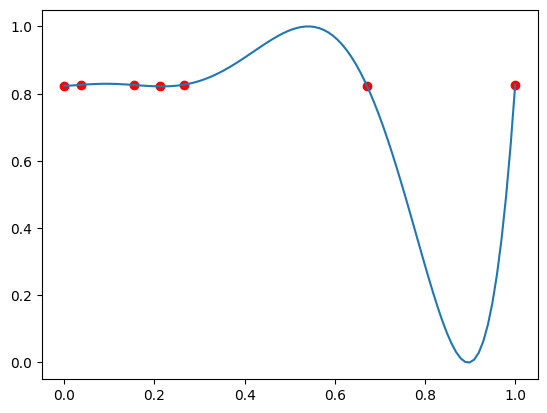

Polynomial Coefficients: [ 8.70949990e+03 -1.82171003e+04  1.23305278e+04 -3.06541689e+03
  2.41261279e+02  1.42408500e+00  4.56968363e-01]


In [ ]:
# Example usage
x, y, x_points, y_points, coefficients = generate_polynomial_from_points(7)
plot_polynomial(x, y, x_points, y_points)


print("Polynomial Coefficients:", coefficients)


Here is a basic network with three hidden layers.  I haven't thought about the exact architecture very much, since this is a toy problem.  

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class PolynomialFitNetwork(nn.Module):
    def __init__(self, k=7, num_samples=100):
        super().__init__()
        self.k = k
        self.num_samples = num_samples
        self.linear_gelu_stack = nn.Sequential(
            nn.Linear(k*2, 512),
            nn.GELU(),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Linear(512, num_samples * 2)  # Output should be num_samples * 2
        )

    def forward(self, x):
        logits = self.linear_gelu_stack(x)
        return logits.view(-1, self.num_samples, 2)  # Reshape to (batch_size, num_samples, 2)

print(PolynomialFitNetwork().to(device))


Using cuda device
PolynomialFitNetwork(
  (linear_gelu_stack): Sequential(
    (0): Linear(in_features=14, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=512, out_features=200, bias=True)
  )
)


## Generate training data

Generate 2M polynomial fits to train with.

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

def prepare_data(num_samples, k, num_polynomials):
    x_data, y_data = [], []
    for _ in range(num_polynomials):
        x, y, x_points, y_points, _ = generate_polynomial_from_points(k, num_samples)
        x_data.append(np.column_stack((x_points, y_points)).flatten())  # Flatten the input points
        y_data.append(np.column_stack((x, y)).flatten())  # Flatten the output points

    x_data = np.array(x_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)

    return x_data, y_data

# Generate the data
num_samples = 100
k = 7
num_polynomials = 2000000
x_data, y_data = prepare_data(num_samples, k, num_polynomials)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x_data)
y_tensor = torch.tensor(y_data)

# Create a DataLoader
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


<ipython-input-4-5d23f79ba6b8>:14: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_points, y_points, k-1)


In [ ]:
# Retrieve the API key from the Colab secret
from google.colab import userdata
import wandb

api_key = userdata.get('WANDB_API_KEY')

# Log in to Weights & Biases
wandb.login(key=api_key)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Train a model

Define a model and training parameters.  I fiddled around a bit to get parameters that seem to work well.

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Initialize the model, loss function, and optimizer
model = PolynomialFitNetwork(k=k, num_samples=num_samples).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
test_data = prepare_data(num_samples, k, 1000)


The function to run the actual training loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb
import os

def train_model(
  model,
  dataloader,
  criterion,
  optimizer,
  scheduler,
  test_data,
  init_wandb: bool = True,
  num_epochs: int = 10,
  epoch_start: int = 1,
  device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
  project_name: str = 'bitnet 1.58b retraining experiments',
  log_interval: int = 1000,

) -> None:

  if init_wandb: wandb.init(project=project_name)

  model.to(device)

  x_test, y_test = test_data
  x_test_tensor = torch.tensor(x_test).to(device)
  y_test_tensor = torch.tensor(y_test).to(device)

  for epoch in range(epoch_start, epoch_start + num_epochs):
    model.train()
    running_loss = 0.0

    current_lr = optimizer.param_groups[0]['lr']
    wandb.log({"learning_rate": current_lr })

    i = 1

    for batch_x, batch_y in dataloader:
      step_loss = 0.0
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      optimizer.zero_grad()
      outputs = model(batch_x)
      loss = criterion(outputs, batch_y.view(-1, num_samples, 2))
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      step_loss += loss.item()
      if i % log_interval == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch {i}/{len(dataloader)}, Loss: {loss.item()}, Running Loss: {running_loss/i}')
        model.eval()
        with torch.no_grad():
          outputs = model(x_test_tensor)
          test_loss = criterion(outputs, y_test_tensor.view(-1, num_samples, 2))
        wandb.log({"epoch": epoch+1, "batch": i, "test_loss": test_loss.item(), "batch_loss": loss.item(), "running_loss": running_loss/i, "step_loss": step_loss/(log_interval)})
      i += 1

    epoch_loss = running_loss / len(dataloader)

    # Log the training loss to W&B
    wandb.log({"epoch": epoch+1, "training_loss": epoch_loss})

    if scheduler: scheduler.step()

    model.eval()
    with torch.no_grad():
      outputs = model(x_test_tensor)
      test_loss = criterion(outputs, y_test_tensor.view(-1, num_samples, 2))

    wandb.log({"epoch": epoch+1, "test_loss": test_loss.item()})

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss}, Test Loss: {test_loss.item()}')

    torch.save(model.state_dict(), os.path.join(wandb.run.dir, f"checkpoint_{epoch}.pt"))



I actually continued training several times, and trained for a total of 41 epochs, reaching a test loss of 0.00447063846513629.  I continued training as long as it appeared we were making significant progress.

In [ ]:
train_model(
  model,
  dataloader,
  criterion,
  optimizer,
  scheduler,
  test_data,
  init_wandb=False,
  epoch_start=11,
)

Epoch [12/10], Batch 1000/62500, Loss: 0.003958837129175663, Running Loss: 0.004011685298057273
Epoch [12/10], Batch 2000/62500, Loss: 0.006312091369181871, Running Loss: 0.004048449061869178
Epoch [12/10], Batch 3000/62500, Loss: 0.002967128762975335, Running Loss: 0.004030661091266666
Epoch [12/10], Batch 4000/62500, Loss: 0.0052260467782616615, Running Loss: 0.004031203381993692
Epoch [12/10], Batch 5000/62500, Loss: 0.003857015399262309, Running Loss: 0.00402635061587207
Epoch [12/10], Batch 6000/62500, Loss: 0.0025375366676598787, Running Loss: 0.004022843399492558
Epoch [12/10], Batch 7000/62500, Loss: 0.004501946736127138, Running Loss: 0.004015209388794444
Epoch [12/10], Batch 8000/62500, Loss: 0.0019263976719230413, Running Loss: 0.0040139897584740535
Epoch [12/10], Batch 9000/62500, Loss: 0.006213699467480183, Running Loss: 0.0040241935746614926
Epoch [12/10], Batch 10000/62500, Loss: 0.0026458536740392447, Running Loss: 0.004029345911048586
Epoch [12/10], Batch 11000/62500, 

In [ ]:
wandb.finish()

batch,▅▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆
batch_loss,▇██▅▅▅▆▃█▂▄▁▂▁▂▆▃▃▁▂▅▂▃▃▃▃▂▁▁▃▁▄▃▁▂▁▁▄▁▂
epoch,▁▁▂▂▂▃▃▃▄▄▁▁▂▂▂▃▃▃▄▄▁▁▁▂▂▂▃▃▄▄▅▅▆▆▆▇▇▇██
learning_rate,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
running_loss,█▅▄▄▅▃▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step_loss,▇██▅▅▅▆▃█▂▄▁▂▁▂▆▃▃▁▂▅▂▃▃▃▃▂▁▁▃▁▄▃▁▂▁▁▄▁▂
test_loss,█▆▅▄▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▆▅▅▅▄▅▃▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,62000
batch_loss,0.0034
epoch,21


In [ ]:
# Function to load a specific checkpoint
def load_checkpoint(epoch, model):
    model.load_state_dict(checkpoints[epoch])
    return model

## Save the model to WandB


In [ ]:
import os
model = load_checkpoint(5, model)
torch.save(model.state_dict(), os.path.join(wandb.run.dir, "model.pt"))


## Load the model from WandB

And validate that it has reasonable test loss

In [ ]:
best_model = wandb.restore('checkpoint_62501.pt', run_path="honicky/bitnet 1.58b retraining experiments/runs/1wn69p90")

In [ ]:
model = PolynomialFitNetwork().to(device)
model.load_state_dict(torch.load(best_model.name))

<All keys matched successfully>

In [ ]:
# Generate some test data
x_test, y_test = prepare_data(num_samples, k, 1000)
x_test_tensor = torch.tensor(x_test).to(device)
y_test_tensor = torch.tensor(y_test).to(device)

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    test_loss = criterion(outputs, y_test_tensor.view(-1, num_samples, 2))
print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0048


## Plot the some polynomials

Lets take a look at the inferred data and see how well our model matches the ground truth

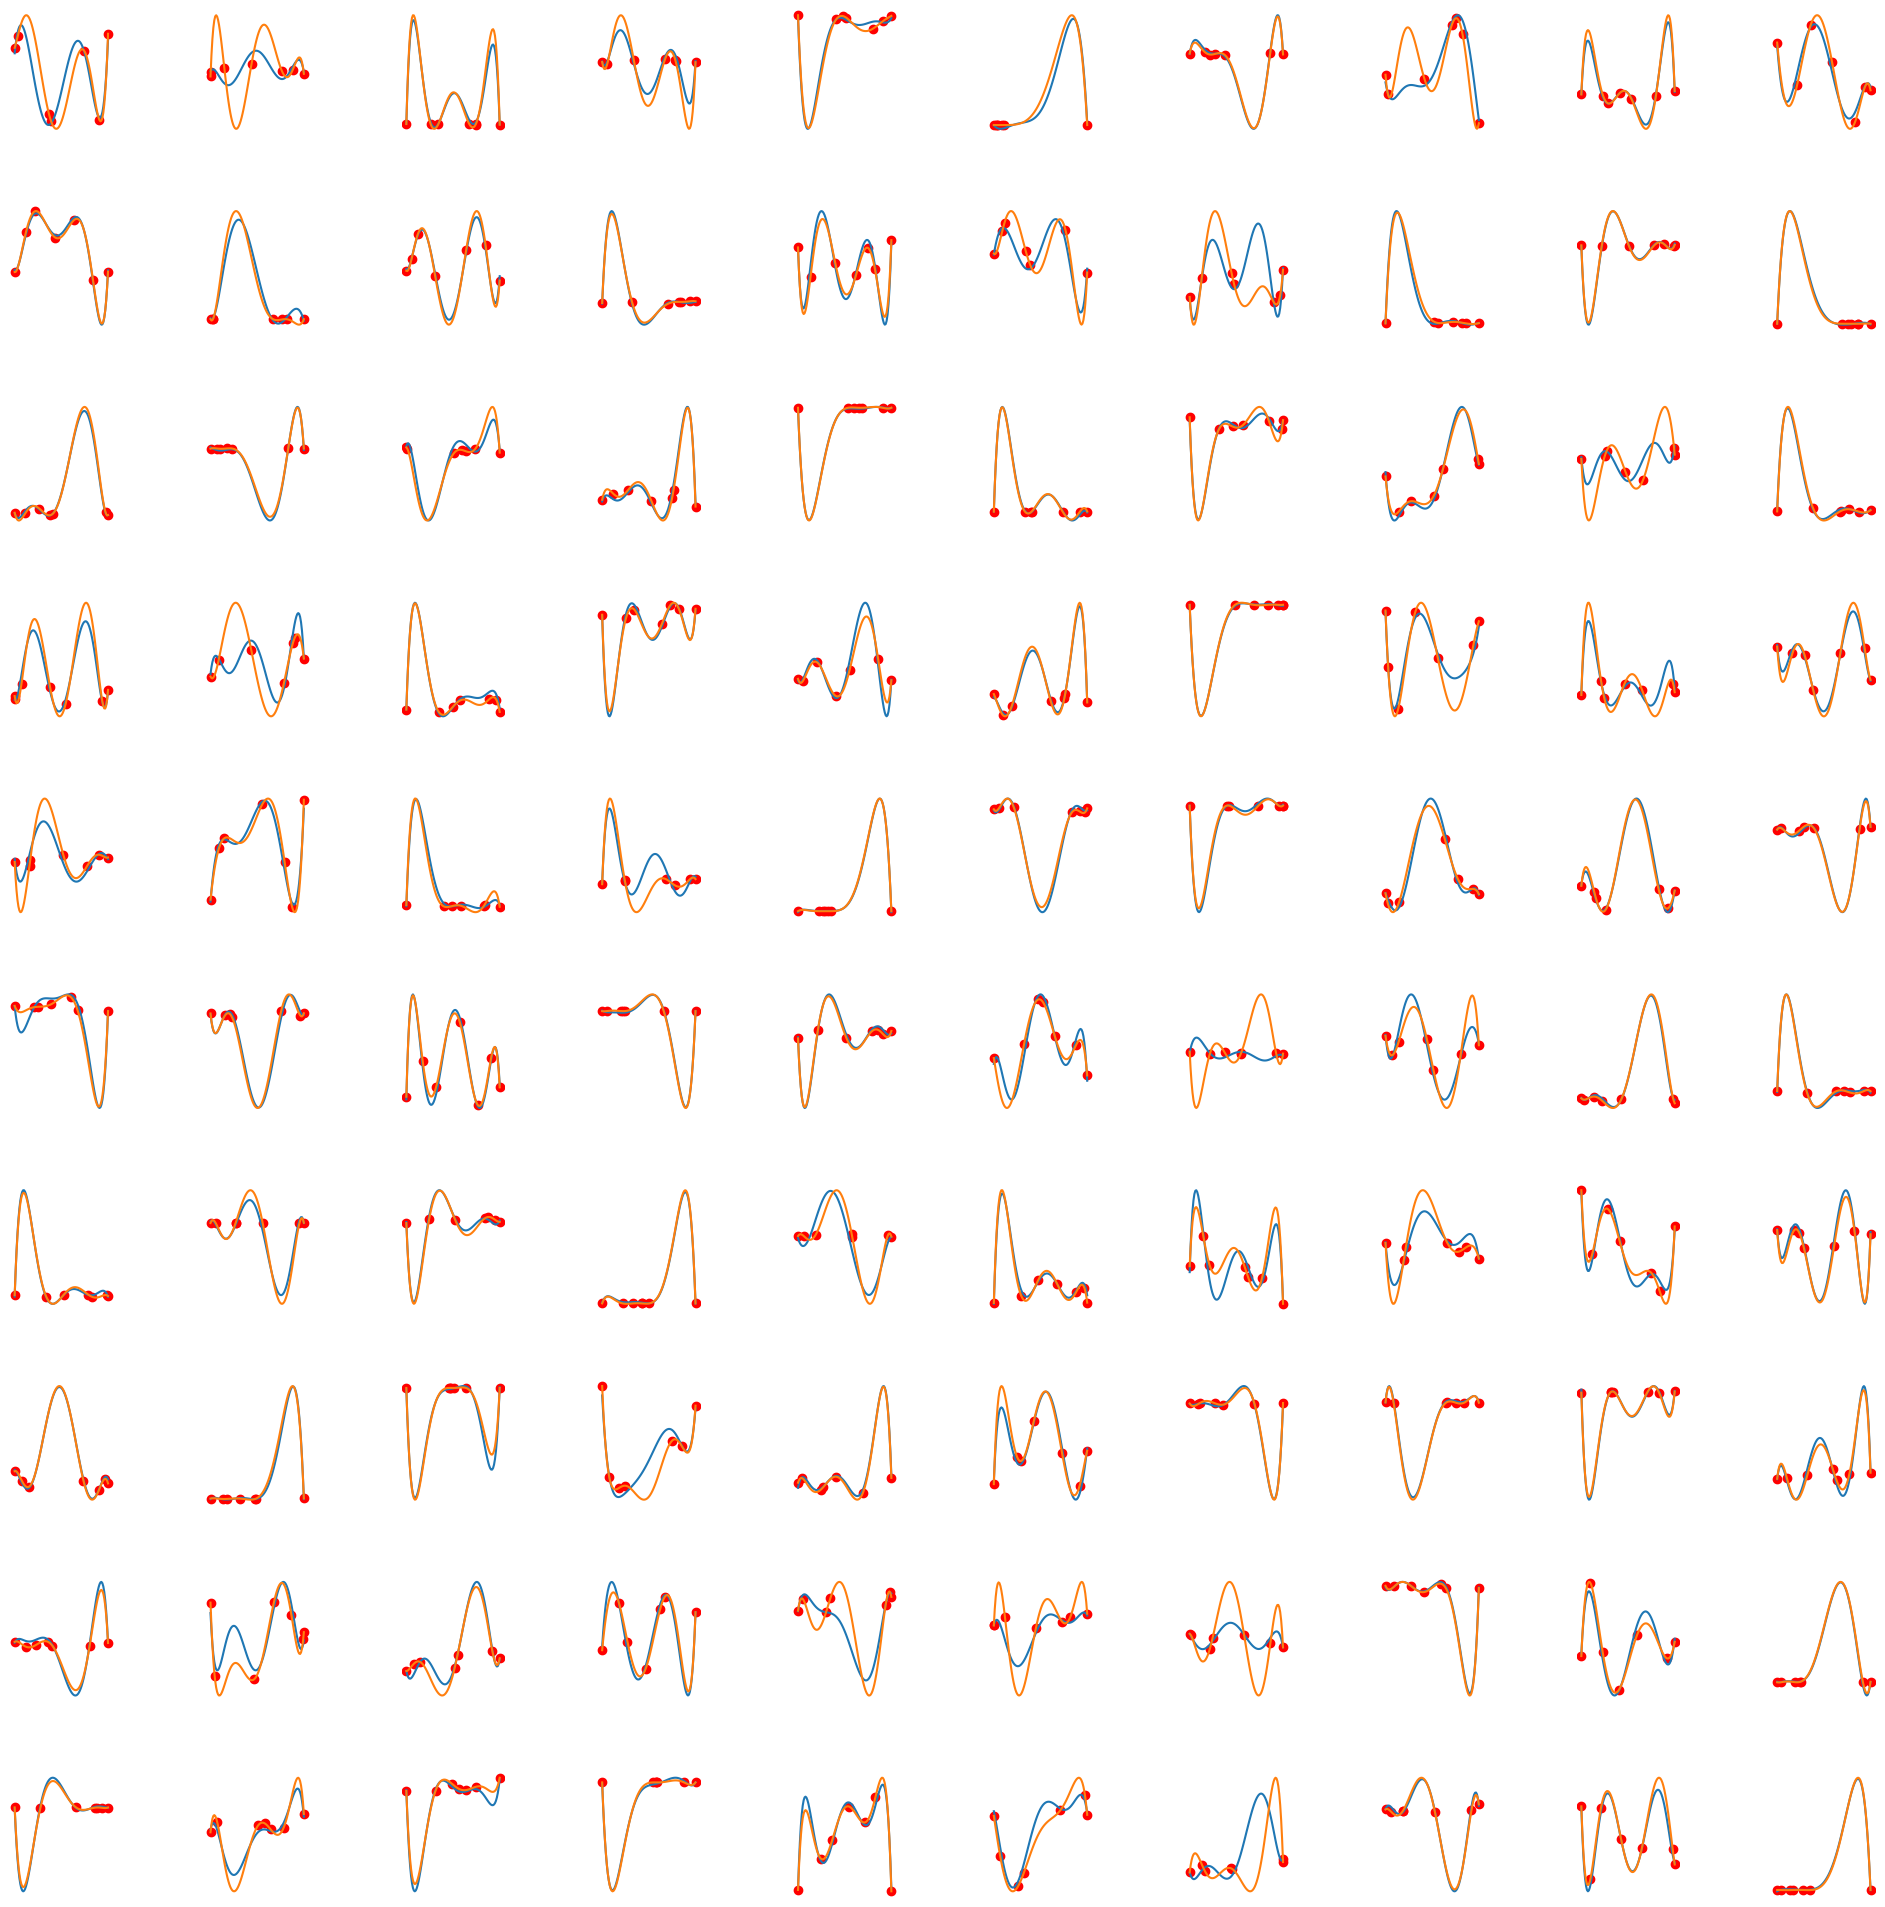

In [ ]:

cpu_outputs = outputs.cpu()
cpu_x_test = x_test_tensor.cpu().view(1000, 7, 2)
cpu_y_test = y_test_tensor.cpu().view(1000, 100, 2)

# Create a 10x10 grid of plots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout(pad=3.0)

for i, ax in enumerate(axes.flatten()):
  if i >= 100:
    break
  ax.plot(cpu_outputs[i,:,0].cpu().numpy(), cpu_outputs[i,:,1].cpu().numpy(), label='Fitted Polynomial')
  ax.plot(cpu_y_test[i,:,0].cpu().numpy(), cpu_y_test[i,:,1].cpu().numpy(), label='Ground Truth')
  ax.scatter(cpu_x_test[i,:,0].cpu().numpy(), cpu_x_test[i,:,1].cpu().numpy(), color='red', label='Random Points')

  # Hide the spines (axis lines)
  # ax.spines['top'].set_visible(False)
  # ax.spines['bottom'].set_visible(False)
  # ax.spines['left'].set_visible(False)
  # ax.spines['right'].set_visible(False)

  ax.axis('off')

plt.show()


That looks pretty good!  Notice that the blue line does not always pass through the orange dots, and that it tends to be off when there are large swings in the function.  

So we now have a reasonable polynomial fit model :)

## The quantized model

Here is a quantized version of the `PolynomialFitNetwork`. It has the exact same structure, and just replaces `nn.Linear` with `BitLinear`.  Since `BitLinear` is a subclass of `nn.Linear`, we will be able to load the weights from the model we just trained into a `BitPolynomialFitNetwork` and continue training.

In [ ]:
from torch import nn
import torch.nn.functional as F

# Assuming BitLinear is defined as provided

# Define model with BitLinear layers
class BitPolynomialFitNetwork(nn.Module):
    def __init__(self, k=7, num_samples=100, weight_bits=1.58):
        super().__init__()
        self.k = k
        self.num_samples = num_samples
        self.weight_bits = weight_bits
        self.linear_gelu_stack = nn.Sequential(
            nn.Linear(k*2, 512),
            nn.GELU(),
            BitLinear(512, 512, weight_bits=weight_bits),
            nn.GELU(),
            BitLinear(512, 512, weight_bits=weight_bits),
            nn.GELU(),
            BitLinear(512, 512, weight_bits=weight_bits),
            nn.GELU(),
            nn.Linear(512, num_samples * 2)  # Output should be num_samples * 2
        )

    def forward(self, x):
        logits = self.linear_gelu_stack(x)
        return logits.view(-1, self.num_samples, 2)  # Reshape to (batch_size, num_samples, 2)

print(BitPolynomialFitNetwork().to(device))


BitPolynomialFitNetwork(
  (linear_gelu_stack): Sequential(
    (0): Linear(in_features=14, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): BitLinear(in_features=512, out_features=512, bias=True)
    (3): GELU(approximate='none')
    (4): BitLinear(in_features=512, out_features=512, bias=True)
    (5): GELU(approximate='none')
    (6): BitLinear(in_features=512, out_features=512, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=512, out_features=200, bias=True)
  )
)


## Load the weights into the `BitPolynomialFitNetwork`

Lets try 8 bits of quantization

In [ ]:
bit_model = BitPolynomialFitNetwork(weight_bits=8).to(device)
bit_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
# Evaluate the model
bit_model.eval()
with torch.no_grad():
    outputs = bit_model(x_test_tensor)
    test_loss = criterion(outputs, y_test_tensor.view(-1, num_samples, 2))
print(f'Test Loss: {test_loss.item()}')

Test Loss: 0.006275698076933622


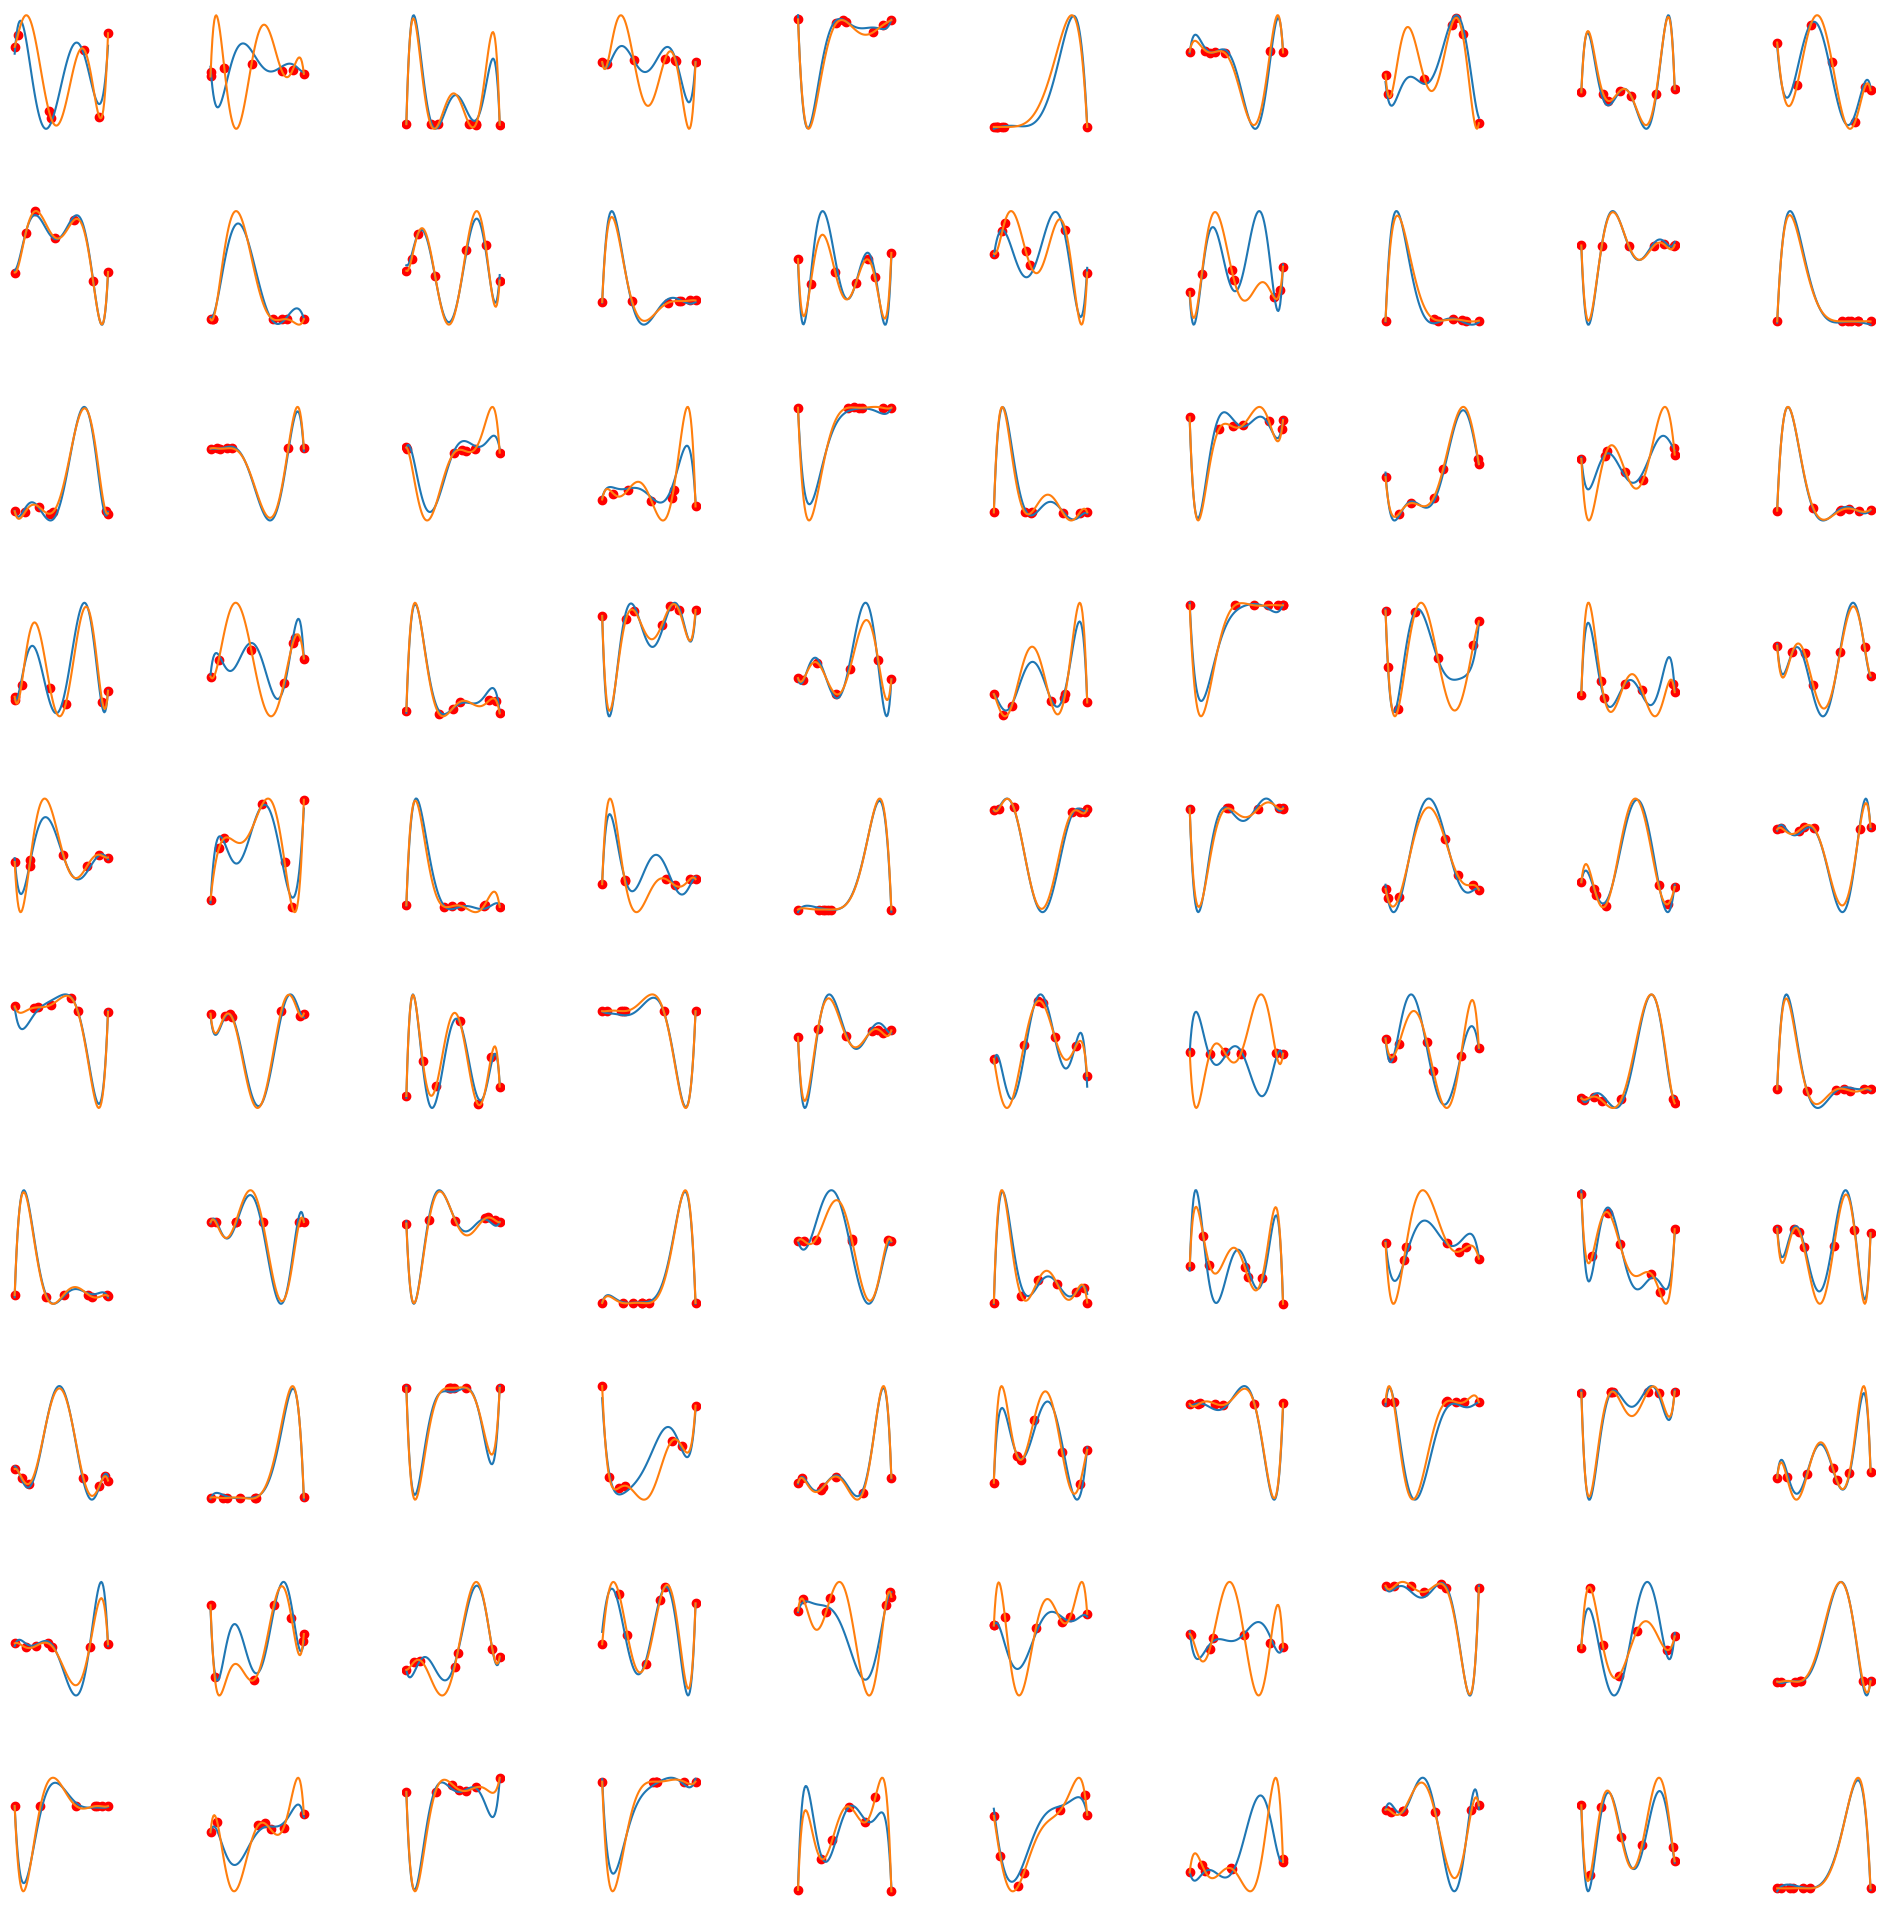

In [ ]:
cpu_outputs = outputs.cpu()
cpu_x_test = x_test_tensor.cpu().view(1000, 7, 2)
cpu_y_test = y_test_tensor.cpu().view(1000, 100, 2)

# Create a 10x10 grid of plots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
fig.tight_layout(pad=3.0)

for i, ax in enumerate(axes.flatten()):
  if i >= 100:
    break
  ax.plot(cpu_outputs[i,:,0].numpy(), cpu_outputs[i,:,1].numpy(), label='Fitted Polynomial')
  ax.plot(cpu_y_test[i,:,0].numpy(), cpu_y_test[i,:,1].numpy(), label='Ground Truth')
  ax.scatter(cpu_x_test[i,:,0].numpy(), cpu_x_test[i,:,1].numpy(), color='red', label='Random Points')

  ax.axis('off')

plt.show()

Looks a bit worse, but not bad still, as we would expect from the loss on eval we did above.

I set the learning rate to a bit above where the we left off training the initial model, and only slowly reduce the learning rate this time, since its already so low

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00002)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
test_data = prepare_data(num_samples, k, 1000)

train_model(
  bit_model,
  dataloader,
  criterion,
  optimizer,
  scheduler,
  test_data,
  init_wandb=True,
)

wandb: Currently logged in as: honicky. Use `wandb login --relogin` to force relogin


Epoch [2/10], Batch 1000/62500, Loss: 0.00738303828984499, Running Loss: 0.005948978979256936
Epoch [2/10], Batch 2000/62500, Loss: 0.003224340034648776, Running Loss: 0.005923625724331942
Epoch [2/10], Batch 3000/62500, Loss: 0.004377288278192282, Running Loss: 0.005978950582638694
Epoch [2/10], Batch 4000/62500, Loss: 0.0037605094257742167, Running Loss: 0.005960544750792906
Epoch [2/10], Batch 5000/62500, Loss: 0.00604893546551466, Running Loss: 0.00594881033366546
Epoch [2/10], Batch 6000/62500, Loss: 0.001894959481433034, Running Loss: 0.005940181380021386
Epoch [2/10], Batch 7000/62500, Loss: 0.0077963354997336864, Running Loss: 0.005932262204071906
Epoch [2/10], Batch 8000/62500, Loss: 0.005334111396223307, Running Loss: 0.00593132451971178
Epoch [2/10], Batch 9000/62500, Loss: 0.006884652189910412, Running Loss: 0.005931702948162435
Epoch [2/10], Batch 10000/62500, Loss: 0.006660765036940575, Running Loss: 0.005926953126525041
Epoch [2/10], Batch 11000/62500, Loss: 0.0048067993

## Disappointment

Meh, neither the test nor training loss went down even after 10 epochs of training!  Lets try training a `BitPolynomialFitNetwork` from scratch, as in the original paper

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Initialize the model, loss function, and optimizer
model = BitPolynomialFitNetwork(k=k, num_samples=num_samples, weight_bits=8).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
test_data = prepare_data(num_samples, k, 1000)

train_model(
  model,
  dataloader,
  criterion,
  optimizer,
  scheduler,
  test_data,
  init_wandb=True,
  num_epochs=41,
)

wandb: Currently logged in as: honicky. Use `wandb login --relogin` to force relogin


Epoch [2/41], Batch 1000/62500, Loss: 0.03575202077627182, Running Loss: 0.03710482292063534
Epoch [2/41], Batch 2000/62500, Loss: 0.032751649618148804, Running Loss: 0.03473307022638619
Epoch [2/41], Batch 3000/62500, Loss: 0.028077473863959312, Running Loss: 0.03278364325935642
Epoch [2/41], Batch 4000/62500, Loss: 0.03420659527182579, Running Loss: 0.03147253772732802
Epoch [2/41], Batch 5000/62500, Loss: 0.02879951149225235, Running Loss: 0.030345218311809002
Epoch [2/41], Batch 6000/62500, Loss: 0.025067124515771866, Running Loss: 0.029220672108698637
Epoch [2/41], Batch 7000/62500, Loss: 0.016942329704761505, Running Loss: 0.02827908985529627
Epoch [2/41], Batch 8000/62500, Loss: 0.020245201885700226, Running Loss: 0.02745687675755471
Epoch [2/41], Batch 9000/62500, Loss: 0.01721908524632454, Running Loss: 0.02677061391549392
Epoch [2/41], Batch 10000/62500, Loss: 0.029114169999957085, Running Loss: 0.02614853253243491
Epoch [2/41], Batch 11000/62500, Loss: 0.018802082166075706, 

Well, the model with 8-bit quantized weights in which we trained with quantized weights from the beginning performs as well as the unquanitzed version (as we would expect if this model behaves the same ways as the model in the BitNet b1.58 paper): 0.00447063846513629 (unquantized) vs  0.004453648347407579 (quantized)

In [ ]:
wandb.finish()

batch,▅▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆
batch_loss,▇█▅▂▄▄▄▃▄▄▃▃▄▃▂▄▃▁▃▂▂▂▃▂▁▂▁▁▃▃▂▁▂▁▂▁▂▅▂▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
running_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step_loss,▇█▅▂▄▄▄▃▄▄▃▃▄▃▂▄▃▁▃▂▂▂▃▂▁▂▁▁▃▃▂▁▂▁▂▁▂▅▂▄
test_loss,█▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,62000
batch_loss,0.00439
epoch,42


## Train a ternary model

Lets see how well we do with a ternary model

In [ ]:

# Initialize the model, loss function, and optimizer
model = BitPolynomialFitNetwork(k=k, num_samples=num_samples, weight_bits=1.58).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
test_data = prepare_data(num_samples, k, 1000)

train_model(
  model,
  dataloader,
  criterion,
  optimizer,
  scheduler,
  test_data,
  init_wandb=True,
  num_epochs=41,
)

Epoch [2/41], Batch 1000/62500, Loss: 0.03972483426332474, Running Loss: 0.040612966632470486
Epoch [2/41], Batch 2000/62500, Loss: 0.03892867639660835, Running Loss: 0.03690130976680666
Epoch [2/41], Batch 3000/62500, Loss: 0.02964085526764393, Running Loss: 0.03500597619327406
Epoch [2/41], Batch 4000/62500, Loss: 0.028461962938308716, Running Loss: 0.03344595088390633
Epoch [2/41], Batch 5000/62500, Loss: 0.03201672062277794, Running Loss: 0.03235714760012925
Epoch [2/41], Batch 6000/62500, Loss: 0.022748619318008423, Running Loss: 0.031590744090576967
Epoch [2/41], Batch 7000/62500, Loss: 0.025628527626395226, Running Loss: 0.03098986144816237
Epoch [2/41], Batch 8000/62500, Loss: 0.023466289043426514, Running Loss: 0.030505986700067298
Epoch [2/41], Batch 9000/62500, Loss: 0.02445433847606182, Running Loss: 0.030116942402596276
Epoch [2/41], Batch 10000/62500, Loss: 0.023102683946490288, Running Loss: 0.029802052993606776
Epoch [2/41], Batch 11000/62500, Loss: 0.02844850905239582,

In [ ]:
wandb.finish()

batch,▅▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆
batch_loss,█▆▅█▅▄▄▄▅▃▄▃▃▄▄▂▃▂▃▂▅▁▂▂▂▂▁▃▂▂▃▁▂▂▂▃▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
running_loss,▁▁▁▃█▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step_loss,█▆▅█▅▄▄▄▅▃▄▃▃▄▄▂▃▂▃▂▅▁▂▂▂▂▁▃▂▂▃▁▂▂▂▃▂▂▂▂
test_loss,▅▄▄█▆▃▄▂█▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,62000
batch_loss,0.00814
epoch,42


For the 1.58b model, we don't do as well as the unquantized model.
 get 0.008185640908777714 test loss (quantized) vs 0.00447063846513629 (unquantized).

 There are so many differences with the LLM in the paper that its hard to draw any conclusions, except that this model is not representative (no surprise there).  I guess we'll need to just try a small LLM (maybe Pythia 14m or Pythia 70m?)


